# Kernel-Galerkin Experiments

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import os
import sys

# Get the current working directory
cwd = os.getcwd()

# Get the parent directory (one level above)
parent_dir = os.path.dirname(cwd)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

## Metrics

The true eigenfunctions, eigenvalues are $(\phi_i, \lambda_i)$, estimates are $(f_i, \hat \lambda_i)$, we write $f: \mathbb{R}^d \to \mathbb{R}^k$. The 'method eigenvalues' are the eigenvalues returned by the method, the 'fitted eigenvalues' are obtained by computing
$$\hat \lambda_j = \text{argmin} \sum_i (\lambda_j f_j(x_i) - \mathcal{L}f_j(x_i))^2$$

### Basic Metrics

- (fitted_)eigen_error:
$$ \mathbb{E}_{x\sim\mu}[(\hat\lambda_j f_j(x) - \mathcal{L}f_j(x))^2] $$

- orth_error:
$$ \frac{1}{k^2}\|\mathbb{E}_{x\sim\mu}\left[f(x)f(x)^T\right] - \text{diag}\left(\mathbb{E}_{x\sim\mu}\left[f(x)f(x)^T\right]\right)\|^2 $$

- eigen_cost:
$$ \sum_{i=1}^k \langle f_i, \mathcal{L} f_i\rangle_\mu = \sum_{i=1}^m \langle \nabla f_i, \nabla f_i\rangle_\mu$$

- (fitted_)eigenvalue_mse:
$$ \frac{1}{k} \sum_{i=1}^k (\lambda_i - \hat\lambda_i)^2 $$

- eigenfunc_mse: 
$$ \frac{1}{k} \sum_{i=1}^k \mathbb{E}_{x\sim \mu} \|f_i(x) - \phi_i(x)\|^2 $$

Important to note here is that we rotate $f$ within each eigenspace in order to align with $\phi$ as much as possible (since eigenfunctions in eigenspace are only defined up to rotation)

### Reconstruction metrics

The idea of the reconstruction metrics is to take a function $g: \mathbb{R}^d \to \mathbb{R}$, and to use the fact that we have
$$g = \sum_{i=1}^\infty \langle g, \phi_i\rangle \phi_i, \quad \mathcal{L}g = \sum_{i=1}^\infty \langle g, \phi_i\rangle \lambda_i\phi_i$$

Thus one way of testing the quality of the learned eigenfunctions is to see how well we can reconstruct $g$ and $\mathcal{L}g$ in this way. The value reported is the MSE of the approximation compared over the variance (in order to be invariant wrt scaling of $g$):
$$\text{Reconstruction Error}(m) = \frac{\mathbb{E}_{x\sim\mu}\left[\left(g(x) - \sum_{i=1}^m \langle g, \hat\phi_i\rangle \hat\phi_i(x)\right)^2\right]}{\text{Var}_{\mu}(g)}$$
$$\mathcal{L}\text{ Reconstruction Error}(m) = \frac{\mathbb{E}_{x\sim\mu}\left[\left(\mathcal{L}g(x) - \sum_{i=1}^m \langle g, \hat\phi_i\rangle \hat\lambda_i\hat\phi_i(x)\right)^2\right]}{\text{Var}_{\mu}(g)}$$

### PDE metrics

This is the 'final' metric we care about: how well does our method perform in solving the PDE. Current implementation takes as its initial value $f_0(x) = \phi_i(x)$ for some eigenfunction, and then the solution to the PDE is $f(x,t) = \phi_i(x) \exp(-\lambda_it)$. Our estimate of the solution is
$$\hat f(x,t) = \sum_{i=1}^k \langle f_0, \hat\phi_i\rangle_\mu\ \hat\phi_i\ e^{-\hat\lambda_i t}$$
and we can report the MSE between $f$ and $\hat f$ for a fixed time.

In [2]:
nonexact_metrics = ['eigen_error', 
                    'fitted_eigen_error',
                    'orth_error',
                    'eigen_cost']

exact_metrics = ['eigenvalue_mse',
                 'fitted_eigenvalue_mse',
                 'eigenfunc_mse']

reconstruction_metrics = ['linear_reconstruction',
                          'linear_L_reconstruction',
                          'quadratic_reconstruction',
                          'quadratic_L_reconstruction',
                          'cubic_reconstruction',
                          'cubic_L_reconstruction']

pde_metrics = ['linear_pde_error',
               'quadratic_pde_error',
               'cubic_pde_error']

### 1d Gaussian

Energy $E = \frac{1}{2}\|x\|^2$. Gaussian kernel. Hyperparameters varied are $p$ (number of basis points) and $\alpha$ (kernel scale)

In [3]:
experiment_name = 'gaussian_20d'
#full_df = pd.read_csv(f'{parent_dir}/experiments/quadratic_energy/{experiment_name}.csv')
#full_df = full_df[full_df['k']>1]
#df = full_df[full_df['k'] == 6].copy()

#df = full_df.copy()
metrics = nonexact_metrics + exact_metrics + reconstruction_metrics + pde_metrics
#full_df.loc[:,metrics] = np.clip(full_df.loc[:,metrics],a_min=1e-7,a_max=1e3)


In [4]:
dfs = []
for i in range(20):
    df = pd.read_csv(f'{parent_dir}/experiments/quadratic_energy/{experiment_name}/{i:04}.csv')
    dfs.append(df)

full_df = pd.concat(dfs)
full_df.dropna(inplace=True)
#big_error = full_df.loc[:,metrics].max(axis=1) > 1e6
#print(f'Dropped {big_error.sum()}/{len(full_df)} rows ({big_error.sum()/len(full_df)*100:.0f} %) for having massive error.')
#full_df = full_df.loc[~big_error]
#full_df = full_df[full_df['p']==300]

mean_df = full_df.groupby(level=0).median()
#std_df = mean_df.copy()
#std_df.loc[:,metrics] = full_df.groupby(level=0).std().loc[:,metrics]
lq_df = mean_df.copy()
uq_df = mean_df.copy()
lq_df.loc[:,metrics] = full_df.groupby(level=0).quantile(0.05).loc[:,metrics]
uq_df.loc[:,metrics] = full_df.groupby(level=0).quantile(0.95).loc[:,metrics]

Below is a heatmap of the various metrics for different hyperparameters.

In [5]:
hyperparams = ['p', 'scale','k','num_samples']

def plot_heatmap(hyperparam_1, hyperparam_2, k, metric):
    if hyperparam_1 == hyperparam_2:
        fig, ax = plt.subplots(figsize=(10,10))
        if hyperparam_1 != 'k':
            df = mean_df[mean_df['k']==k].copy()
            #err_df = std_df[std_df['k']==k].copy()
            lower_df = lq_df[lq_df['k']==k].copy()
            upper_df = uq_df[uq_df['k']==k].copy()
        else:
            df = mean_df.copy()
            #err_df = std_df.copy()
            lower_df = lq_df.copy()
            upper_df = uq_df.copy()
        
        for param in hyperparams:
            if param != 'k' and param not in [hyperparam_1,hyperparam_2]:
                best_param = df.groupby(param).min(metric)[metric].sort_values().index[0]
                df = df[df[param] == best_param].copy()
                #err_df = err_df[err_df[param] == best_param].copy()
                lower_df = lower_df[lower_df[param] == best_param].copy()
                upper_df = upper_df[upper_df[param] == best_param].copy()

        label = metric
        df[metric] = np.clip(np.log10(df[metric]),a_min=-7,a_max=3)
        df['scale'] = np.log10(df['scale'])
        df['num_samples'] = np.log10(df['num_samples'])
        label += ' (log)'
        sns.lineplot(df, x = hyperparam_1, y = metric, ax = ax)
        ax.fill_between(df[hyperparam_1], np.log10(lower_df[metric]), np.log10(upper_df[metric]),alpha=0.3)
        ax.set_title(label)
        #plt.ylim(-3,3)

    else:
        if 'k' not in [hyperparam_1,hyperparam_2]:
            df = mean_df[mean_df['k']==k].copy()
        else:
            df = mean_df
        
        pivot_table = pd.pivot_table(df, index = hyperparam_1, columns = hyperparam_2, values = metric, aggfunc = 'min')
        pivot_table.index = pivot_table.index.map(lambda x: f"{x:.2e}")
        pivot_table.columns = pivot_table.columns.map(lambda x: f"{x:.2f}") 

        label = metric
        pivot_table = np.clip(np.log10(pivot_table),a_min=-7,a_max=3)
        label += " (log)"
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(pivot_table,
                    cmap='viridis',
                    ax = ax)
        ax.set_title(label)

widgets.interact(plot_heatmap, hyperparam_1=hyperparams, hyperparam_2=hyperparams, k = 1+np.arange(200), metric=metrics)


interactive(children=(Dropdown(description='hyperparam_1', options=('p', 'scale', 'k', 'num_samples'), value='…

<function __main__.plot_heatmap(hyperparam_1, hyperparam_2, k, metric)>

plot 1D

In [20]:
hyperparams = ['p', 'scale','k', 'num_samples']

# hyperparam 1 gives x axis
# metric gives y axis
# hyperparam 2 gives color

def plot_line(hyperparam_1, hyperparam_2, k, metric):
    fig, ax = plt.subplots(figsize=(10,10))
    if hyperparam_1 != 'k' and hyperparam_2 != 'k':
        df = full_df[full_df['k']==k].copy()
    else:
        df = full_df.copy()
    label = metric
    df[hyperparam_2] = np.log10(df[hyperparam_2])
    df[metric] = np.clip(np.log10(df[metric]),a_min=-7,a_max=3)
    df['num_samples'] = np.log10(df['num_samples'])

    if hyperparam_2 != hyperparam_1:
        sns.lineplot(df, 
                    x = hyperparam_1, 
                    y = metric, 
                    hue = hyperparam_2,
                    ax = ax,
                    palette = 'coolwarm',
                    estimator='mean')
    else:
        sns.lineplot(df, 
                    x = hyperparam_1, 
                    y = metric, 
                    ax = ax)
    ax.set_title(label)
    plt.ylim(None,0.2)

widgets.interact(plot_line, hyperparam_1=hyperparams, hyperparam_2=hyperparams, k = 1+np.arange(200), metric=metrics)


interactive(children=(Dropdown(description='hyperparam_1', options=('p', 'scale', 'k', 'num_samples'), value='…

<function __main__.plot_line(hyperparam_1, hyperparam_2, k, metric)>

Correlation between metrics. Not very useful for metrics that span different orders of magnitude.

In [6]:
def plot_correlation(k):
    df = np.log(full_df.query(f'k == {k}'))

    corr = df.loc[:,metrics].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    corr = corr.mask(mask)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation'})
    plt.title(f'Correlation Heatmap (k = {k})')
    plt.show()

widgets.interact(plot_correlation, k = np.arange(100)+1)

interactive(children=(Dropdown(description='k', options=(np.int64(1), np.int64(2), np.int64(3), np.int64(4), n…

<function __main__.plot_correlation(k)>

Comparison between fitted eigenvalues and method eigenvalues. The idea was to see whether the inexact metric (fitted_eigen_error) is related to the MSE of the fitted eigenvalues.

In [7]:
def compare_eigvals(k):
    df = full_df.query(f'k == {k}').copy()
    fig, axes = plt.subplots(1,2,figsize=(14,7))
    df['log_kernel_scale'] = np.log10(df['scale'])
    df['size'] = df['p']/10

    #df['size'] = (df['num_samples'] - df['num_samples'].min())/(df['num_samples'].max()-df['num_samples'].min())*15
    df.plot.scatter(x='fitted_eigen_error',
                    y='fitted_eigenvalue_mse',
                    ax=axes[0],
                    c='log_kernel_scale',
                    s='size',
                    cmap='coolwarm',
                    label = 'fitted eigvals',alpha=0.3)

    df.plot.scatter(x='eigen_error',
                    y='eigenvalue_mse',
                    ax=axes[1],
                    c='log_kernel_scale',
                    s='size',
                    cmap='coolwarm',
                    label = 'method eigvals',alpha=0.3)

    axes[0].set_title('Fitted eigvals')
    axes[1].set_title('Method eigvals')

    for ax in axes:
        ax.set_xlim(1e-8,1e4)
        ax.set_ylim(1e-13,1e4)

        ax.set_xscale('log')
        ax.set_yscale('log')

widgets.interact(compare_eigvals, k = 1+np.arange(100))

interactive(children=(Dropdown(description='k', options=(np.int64(1), np.int64(2), np.int64(3), np.int64(4), n…

<function __main__.compare_eigvals(k)>

Compare two metrics:

In [57]:
full_df.iloc[:] = np.where(full_df,np.inf,np.nan)

/tmp/ipykernel_1756164/1060246295.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[inf inf inf ... inf inf inf]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_df.iloc[:] = np.where(full_df,np.inf,np.nan)


In [8]:
full_df['log_kernel_scale'] = np.log10(full_df['scale'])

def compare_metrics(metric_1,metric_2, k):
    if metric_1 == metric_2:
        print('Error: choose different metrics.')
        return None
    
    df = full_df.query(f'k == {k}').copy()
    #df = full_df[full_df['k']>1].copy()

    fig, ax= plt.subplots(figsize=(10,10))

    df['size'] = df['k']*5
    df.loc[:,[metric_1,metric_2]] = np.clip(df.loc[:,[metric_1,metric_2]],a_min=0,a_max=1)
    df.plot.scatter(x=metric_1,
                    y=metric_2,
                    ax=ax,
                    c='log_kernel_scale',
    #               s = 'size',
                    cmap='coolwarm',
                    alpha = .5)
    ax.set_xscale('log')
    ax.set_yscale('log')

widgets.interact(compare_metrics, metric_1 = metrics, metric_2 = metrics, k = widgets.IntSlider(min=2,max=15))

interactive(children=(Dropdown(description='metric_1', options=('eigen_error', 'fitted_eigen_error', 'orth_err…

<function __main__.compare_metrics(metric_1, metric_2, k)>

ValueError: Could not interpret value `L_quadratic_reconstruction` for `y`. An entry with this name does not appear in `data`.

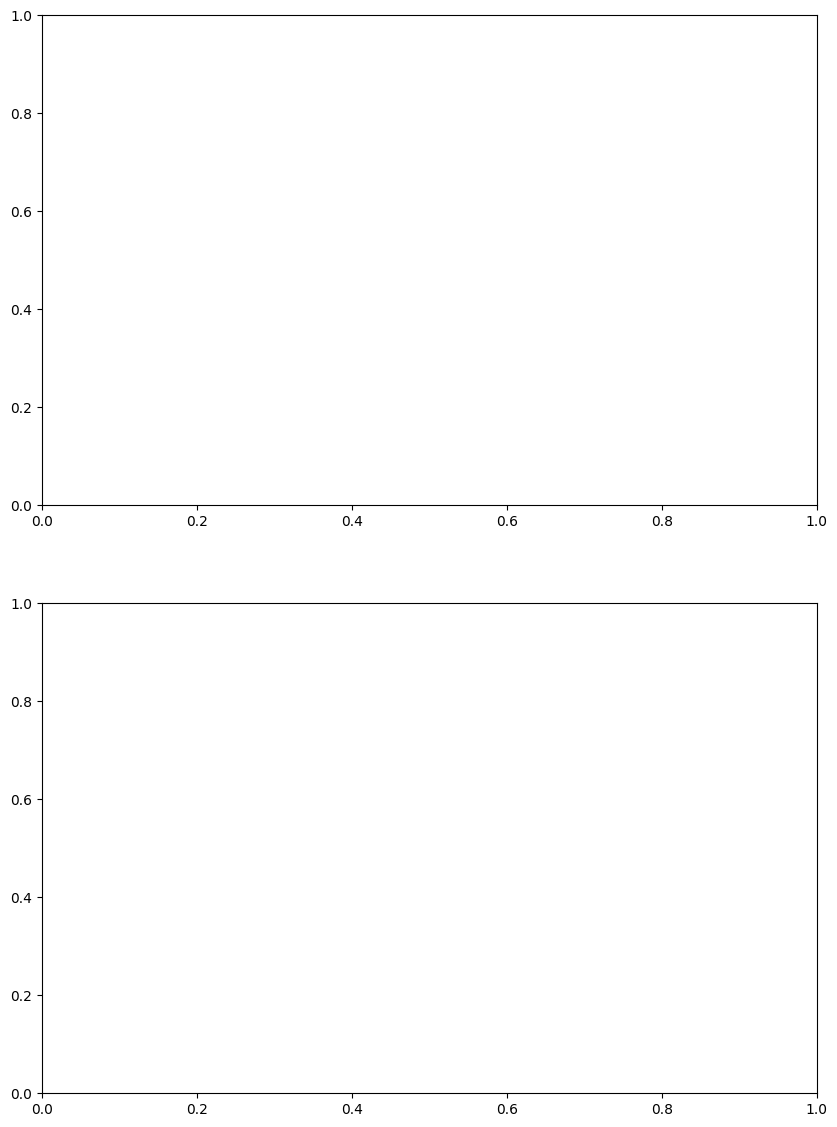

In [28]:
metrics = ['L_quadratic_reconstruction','fitted_eigen_error']

fig, axes = plt.subplots(len(metrics),1,figsize=(10,7*len(metrics)))
full_df['log_kernel_scale'] = np.log(full_df['scale'])
df = full_df[(full_df['p'] == 300) & (full_df['k'] > 1)].copy()

hyperparam = 'k'
for i, metric in enumerate(metrics):
    sns.lineplot(full_df,x= hyperparam,
                 y= metric,
                 hue = 'log_kernel_scale',
                 ax = axes[i],
                 palette='coolwarm')
    if metric not in reconstruction_metrics:
        axes[i].set_yscale('log')
    else:
        axes[i].set_ylim(0,1)

In [36]:
df['log_kernel_scale']

0       0.000000
1       0.210526
2       0.421053
3       0.631579
4       0.842105
          ...   
5995    3.157895
5996    3.368421
5997    3.578947
5998    3.789474
5999    4.000000
Name: log_kernel_scale, Length: 60000, dtype: float64

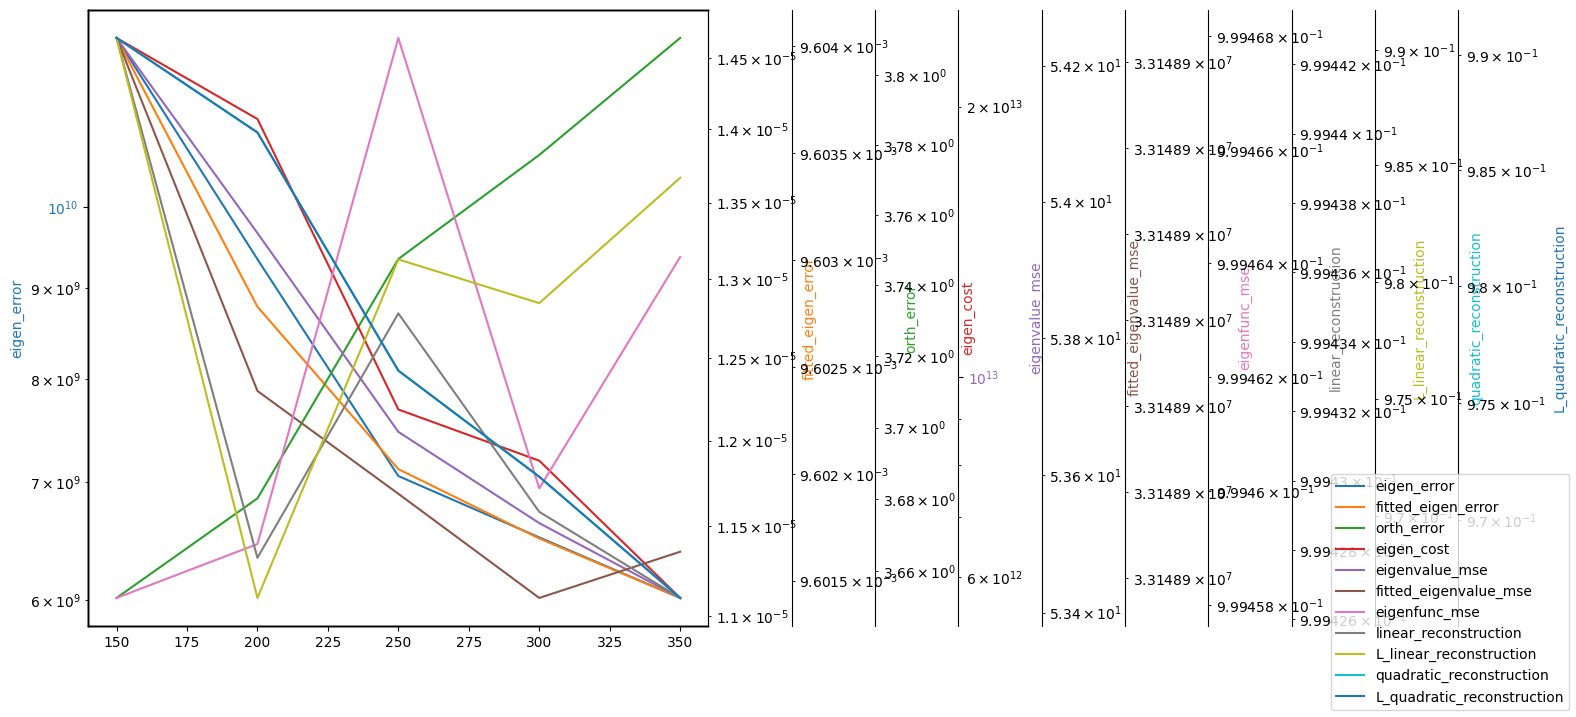

In [38]:
hyperparam = 'p'

agg_df = df[(df['log_kernel_scale'] >= 3) & (df['log_kernel_scale'] <= 3.2)].groupby(hyperparam)[metrics].mean().sort_index()
# Create a figure
fig, ax = plt.subplots(figsize=(8,8))

# Store axes for later adjustments
axes = [ax]

# Plot the first column
ax.plot(agg_df.index, agg_df.iloc[:, 0], label=agg_df.columns[0], color="C0")
ax.set_ylabel(agg_df.columns[0], color="C0")
ax.tick_params(axis="y", labelcolor="C0")

# Add additional axes for other columns
colors = plt.cm.tab10.colors  # Use a colormap for unique colors
for i, column in enumerate(agg_df.columns[1:], start=1):
    new_ax = ax.twinx()
    new_ax.spines["right"].set_position(("outward", 60 * (i - 1)))  # Offset by 60 points per axis
    new_ax.plot(agg_df.index, agg_df[column], label=column, color=colors[i % len(colors)])
    new_ax.set_ylabel(column, color=colors[i % len(colors)])
    new_ax.tick_params(axis="y", labelcolor=colors[i % len(colors)])
    axes.append(new_ax)

# Add a legend
fig.legend(agg_df.columns, loc="lower right")
for ax in axes:
    ax.set_yscale('log')

KeyboardInterrupt: 

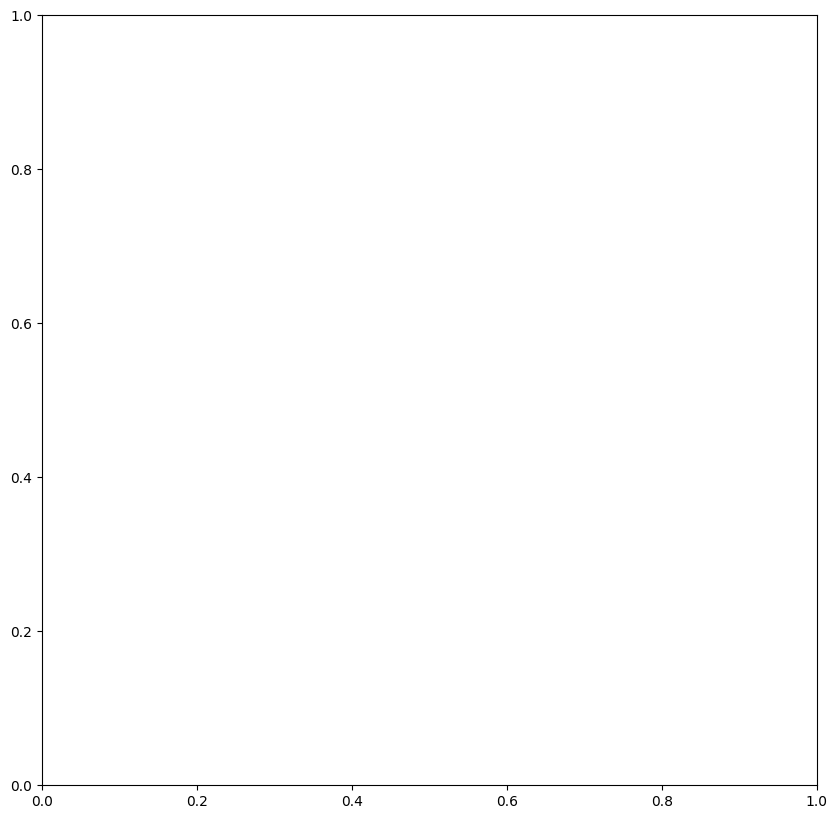

In [59]:
fig, ax = plt.subplots(figsize=(10,10))

lines1 = sns.lineplot(df,
                      x='k',
                      y='eigen_cost',
                      hue='log_kernel_scale',
                      palette='coolwarm',
                      ax=ax, 
                      estimator = 'mean',
                      errorbar='ci')

plt.legend()

plt.yscale('log')  

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

lines1 = sns.lineplot(df,
                      x='k',
                      y='quadratic_reconstruction',
                      hue='log_kernel_scale',
                      palette='coolwarm',
                      ax=ax, 
                      estimator = 'mean',
                      errorbar='ci')

lines2 = sns.lineplot(df,
                      x='k',
                      y='L_quadratic_reconstruction',
                      hue='log_kernel_scale',
                      palette='coolwarm',
                      ax=ax, 
                      estimator = 'mean',
                      errorbar='ci', ls = '--')

plt.legend()

plt.ylim(0,1)  

### 20d Gaussian

To be more in the regime that we care about, this is an experiment for $d=20$

In [46]:
experiment_name = 'gaussian_20d'
df = pd.read_csv(f'{parent_dir}/experiments/quadratic_energy/{experiment_name}.csv')

In [49]:
df['size'] = df['k']/5
df['log_kernel_scale'] = np.log10(df['scale'])

/tmp/ipykernel_612492/790230385.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


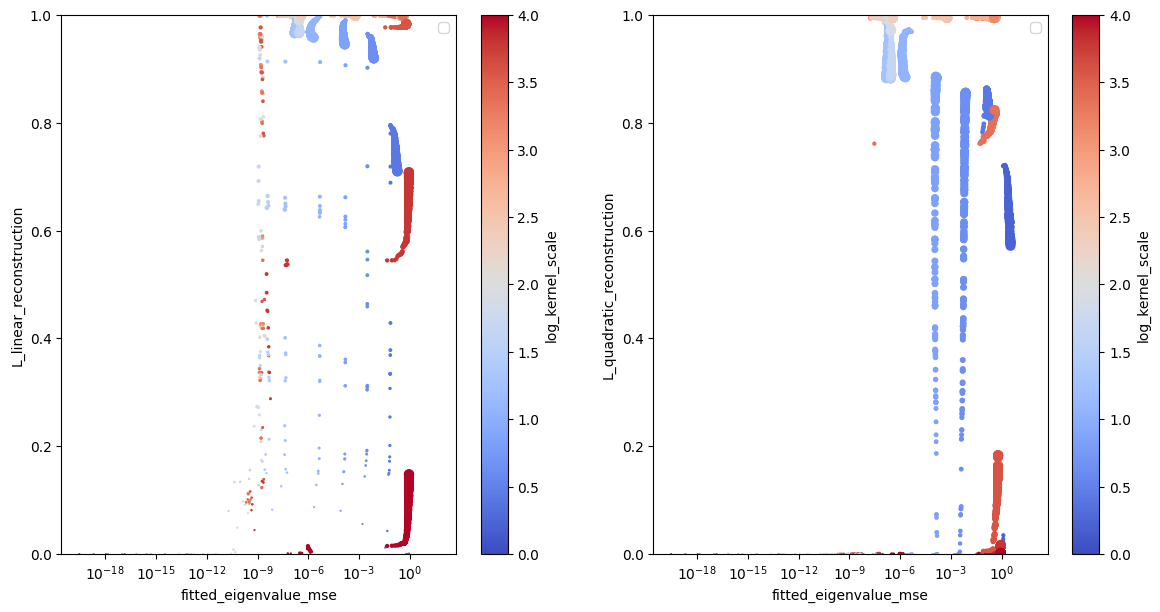

In [50]:
fig, axes = plt.subplots(1,2,figsize=(14,7))
df['log_kernel_scale'] = np.log10(df['scale'])
#df['p_size'] = (df['p'] - df['p'].min())/(df['p'].max()-df['p'].min())*15
#df['reg_size'] = -np.log10(df['L_reg'])*3
df.plot.scatter(x='fitted_eigenvalue_mse',
                y='L_linear_reconstruction',
                ax=axes[0],
                c='log_kernel_scale',
                s='size',
                cmap='coolwarm')

df.plot.scatter(x='fitted_eigenvalue_mse',
                y='L_quadratic_reconstruction',
                ax=axes[1],
                c='log_kernel_scale',
                s='size',
                cmap='coolwarm')

for ax in axes:

    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim(0,1)
    #ax.set_xlim(1e-6,1e2)
    #ax.vlines(20,0,1,color='black',ls='--', label = 'min_cost')
    ax.legend()
